# 03 Response surfaces

One fruitful application that employs the existence of an Active Subspace is the design of response surfaces, see [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies](https://doi.org/10.1137/1.9781611973860). In particular we will build response surfaces with Gaussian process regression. 

We will show the better results obtained by the optimal profile that theoretically establishes the optimal a priori estimate of the root mean square error on the ridge approximation, see also [Zahm, Olivier, Paul G. Constantine, Clementine Prieur, and Youssef M. Marzouk. "Gradient-based dimension reduction of multivariate vector-valued functions."](https://epubs.siam.org/doi/pdf/10.1137/18M1221837).

To have a clear view on the procedure the following are the approximations involved

$$\large
f(\mathbf{X}) \approx g_{\epsilon, \omega}(\mathbf{W}_1\mathbf{X})\approx
    \hat{g}_{\epsilon, \omega, M}(\hat{\mathbf{W}}_1\mathbf{X})\approx
    \mathscr{R}_{\epsilon,\omega,M,\delta}(\hat{\mathbf{W}}_1\mathbf{X}), 
$$

1. approximation with the exact optimal profile and exact gradients $g_{\epsilon, \omega}=\mathbb{E}_{\rho}[f|\mathbf{W}_{1}\mathbf{X}]$
2. approximation of the correlation matrix $\mathbf{C}$ with Monte Carlo and use of approximated gradients: $g_{\epsilon, M, \omega}(\hat{\mathbf{W}}_1\mathbf{X})$
3. regression with Gaussian processes: $\mathscr{R}_{\epsilon,\omega,M,\delta}(\hat{\mathbf{W}}_1\mathbf{X})$

The library we use for Gaussian process regression is [GPy](https://github.com/SheffieldML/GPy) and for Hamiltonian Monte Carlo [pyhmc](https://github.com/rmcgibbo/pyhmc).

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt
from functools import partial

import GPy
from pyhmc import hmc
from queue import Queue
from threading import Thread
import timeit

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

from data.numpy_functions import sin_2d, radial

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

# Global parameters
n_samples = 50
input_dim = 5

In [3]:
# Uniformly distributed inputs
lb = 0 * np.ones(input_dim)
ub = 2 * np.ones(input_dim)

def inputs_uniform(n_samples, n_pars, lb,  ub):
    return np.vstack(
        np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(n_pars)]).T)

In [4]:
# Gaussian model for the inputs
mean = np.ones(input_dim)
cov = 0.5*np.diag(np.ones(input_dim))

def inputs_gaussian(n_samples, mean, cov):
    return np.random.multivariate_normal(mean, cov, n_samples)

The model of interest is an hyperparaboloid. We define also the optimal profile $\mathbb{E}_{\rho}[f|W_{1}^{T}\mathbf{X}]$ that will be used instead of the model $f(W_{1}^{T}\mathbf{X})$ achieving the theoretical optimal a priori estiamte.

In [5]:
def generatrix(x):
    return x

def output(x, normalizer, r):
    return r(np.linalg.norm(normalizer.inverse_transform(x)**2, axis=1)**2)

def profile(active, ss, f_out, N=10):
    return (1/N)*np.sum(np.array([f_out(ss.inverse_transform(active)[0]) for i in range(N)]), axis=0)

In [6]:
# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub) #X = inputs_gaussian(M, mean, cov)
nor = Normalizer(lb, ub)
x = nor.fit_transform(X)

# Define the output of interest and compute the gradients
func = partial(output, normalizer=nor, r=generatrix)
f = func(x)
df = egrad(func)(x)

We compute the active subspace and use the method ActiveSubspaces.backward to approximate with Monte Carlo the optimal profile 

$$\mathbb{E}_{\rho}[f|W_{1}^{T}\mathbf{X}]\approx\frac{1}{N}\sum_{i=1}^{N}f(W_{1}Y+W_{2}\mathbf{Z}_{i})$$

where $\mathbf{Y}=W_{1}^{T}\mathbf{X}$ and $\mathbf{Z}=W_{2}^{T}\mathbf{X}$ are the active and inactive variables respectively. The optimal profile depends only on the variables $\mathbf{Y}$ while the inactive ones are sampled from the conditional distribution $p(\mathbf{z}|\mathbf{y})$: this is done with importance sampling inside athena, but is implemented only for the uniform distirbution. For a more general distribution we will use Hamiltonian Monte Carlo.

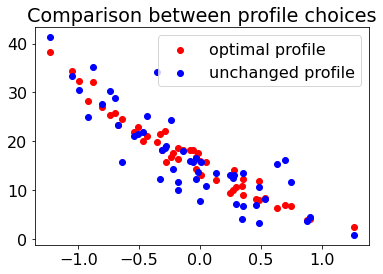

In [7]:
# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)

M_test = 50
X_test = inputs_uniform(M_test, input_dim, lb, ub)
nor = Normalizer(lb, ub)
x_test = nor.fit_transform(X_test)
f_test = func(x_test)
x_forward = asub.transform(x_test)[0]
g = profile(x_forward, asub, func)
plt.scatter(x_forward, g, c='r', label='optimal profile')
plt.scatter(x_forward, f_test, c='b', label='unchanged profile')
plt.legend()
plt.title('Comparison between profile choices')
plt.show()

Optimization restart 1/5, f = 106.91740601066249
Optimization restart 2/5, f = 106.91740601556594
Optimization restart 3/5, f = 106.91740601143076
Optimization restart 4/5, f = 106.91740601306333
Optimization restart 5/5, f = 106.91740601964506
Optimization restart 1/5, f = 154.55446433960142
Optimization restart 2/5, f = 154.55446433979242
Optimization restart 3/5, f = 154.55446433981598
Optimization restart 4/5, f = 154.55446433968393
Optimization restart 5/5, f = 154.55446433960347


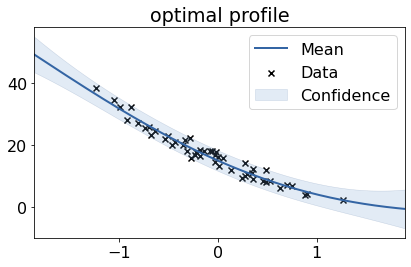

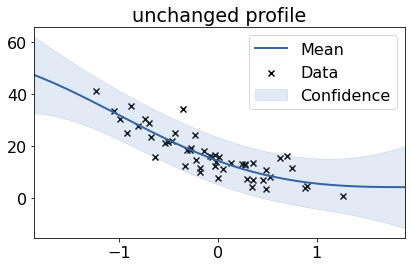

Relative Root Mean Square Error for optimal profile 11.369%
Relative Root Mean Square Error for unchanged profile 31.348%


In [8]:
gp_g = GPy.models.GPRegression(x_forward, g.reshape(-1, 1))
gp_f = GPy.models.GPRegression(x_forward, f_test.reshape(-1, 1))

gp_g.constrain_positive('')
gp_g.optimize_restarts(5)

gp_f.constrain_positive('')
gp_f.optimize_restarts(5)

y_g = gp_g.predict(x_forward)[0]
y_f = gp_f.predict(x_forward)[0]

gp_g.plot(title="optimal profile")
gp_f.plot(title="unchanged profile")

plt.show()

def RRMSE(test, true):
    return np.sqrt(np.sum((test.reshape(-1) - true.reshape(-1))**2) )#/ np.sum((true - true.mean())**2))

print("Relative Root Mean Square Error for optimal profile {:.3f}%".format(RRMSE(y_g, g)))
print("Relative Root Mean Square Error for unchanged profile {:.3f}%".format(RRMSE(y_f, f_test)))

### Remarks

Try to change the output of interest. What is the effect of choosing the optimal profile from the practical point of view of building a response surface?

# Response surfaces with HMC

A part from the uniform distribution for which an importance sampling algorithm is efficient to sample from the conditional distribution $p(z|y)$, in the general case sampling can be achieved with more advanced methods like Hamiltonian Monte Carlo.

In the following case we consider the inputs distributed according to the probability density function

$$\large
p(y, z) \propto \exp\left(-\frac{1}{20}\left(\lVert \mathbf{W}_{1}y+\mathbf{W}_{2}z- 5c\rVert^{2}_{2}\right)-\frac{1}{20}\left(\lVert \mathbf{W}_{1}y+\mathbf{W}_{2}z- c\rVert^{2}_{2}\right)\right)
$$

where $c$ is a constant vector with the same dimension of the input space and ones as components.

In [9]:
# Global parameters
n_samples = 500
input_dim = 2

In [10]:
# logarithm of the probability density p(x)=p(y, z)
def log_proposal(x, V):
    dV = egrad(V)
    return V(x), dV(x)


# logarithm of the conditional probability density p(z|y)
def log_inactive_con_active(z, y, ss, V):
    func_z = lambda z_: V(ss.W1 * y + ss.W2 * z_)
    dfunc_z = egrad(func_z)
    return func_z(z), dfunc_z(z)

# optimal profile
def profile(active, ss, f_out, N=10):
    """
    Optimal profile of AS ridge approximation.
    :param ndarray active: active variables at which the optimal profile will be queried at
    :param ActiveSubspace ss: active subspaces of output of interest
    :param function f_out: output of interest
    :param int N: number of Monte Carlo samples
    :rtype: ndarray
    """
    y = np.array([active])
    pr_args = (y, ss, V)
    inactive = chains(log_inactive_con_active,
                      1,
                      n_samples=N,
                      epsilon=0.2,
                      pr_args=pr_args,
                      dim=1,
                      n_burn=100)
    x = np.hstack((y * np.ones((10, 1)), inactive)).dot(ss.evects.T)
    return (1 / N) * np.sum(f_out(x))

In [11]:
# Potential
V = lambda x_: -(0.5 * (1 / 10) * np.linalg.norm(x_ - 5*np.ones([input_dim]))**2
                 ) - 0.5 * (1 / 10) * np.linalg.norm(x_ - 1*np.ones([input_dim]))**2

Parallel implementation of sampling procedure with hmc.

In [12]:
def chains(proposal, N, **kwargs):
    """
    Sample from log probability density function proposal,
    with N threads.
    """
    q = Queue()
    threads = []
    thread_ind(proposal, N, q, threads, kwargs)

    for t in threads:
        t.join()

    results = []
    while True:
        if not q.empty():
            results.append(q.get())
        else:
            break
    return np.vstack(results)

def thread_ind(proposal, N, q, threads, kwargs):
    for i in range(N):
        t = Thread(target=func_thread, args=(proposal, q), kwargs=kwargs)
        t.start()
        threads.append(t)
        
def func_thread(proposal, queue, **kwargs):
    """
    Sample from log probability density function proposal with pyhmc,
    see https://github.com/rmcgibbo/pyhmc for tutorials.
    """
    res = hmc(proposal,
              args=(*kwargs['pr_args'], ),
              x0=np.random.randn(kwargs['dim']) + 1.5 * np.ones(kwargs['dim']),
              n_samples=kwargs['n_samples'],
              display=True,
              n_steps=40,
              n_burn=kwargs['n_burn'],
              epsilon=kwargs['epsilon'],
              return_diagnostics=True)
    queue.put(res[0])

Sample inputs from $p(x)\sim\exp(-V(x))$ in parallel.

In [13]:
t3 = timeit.default_timer()
X = chains(log_proposal,
           1,
           n_samples=1000,
           epsilon=0.1,
           pr_args=(V, ),
           dim=input_dim,
           n_burn=1000)
print("timer {} s".format(timeit.default_timer() - t3))

New position is
 [6.91758553 5.15260312]
Finished step -1000  Threshold: 0.382185

New position is
 [ 4.37243655 -1.11385692]
Finished step -999  Threshold: 1.05986

New position is
 [3.89356198 2.18735979]
Finished step -998  Threshold: 2.36128

New position is
 [ 6.59443904 -1.35062795]
Finished step -997  Threshold: 0.222007

New position is
 [8.92022452 1.92305428]
Finished step -996  Threshold: 0.805753

New position is
 [ 9.57465204 -0.72593678]
  Sample rejected -995.  Threshold: 0.355198

New position is
 [3.72138952 1.3978024 ]
Finished step -994  Threshold: 5.15706

New position is
 [-0.93457007 -0.06034548]
Finished step -993  Threshold: 0.340398

New position is
 [ 4.20005442 -1.80573099]
Finished step -992  Threshold: 1.01554

New position is
 [10.02661407  1.30930787]
Finished step -991  Threshold: 0.253676

New position is
 [1.87569259 4.17782548]
Finished step -990  Threshold: 11.6524

New position is
 [3.72683472 3.71572856]
Finished step -989  Threshold: 1.08304

New 

 [10.1023178  -0.22681935]
  Sample rejected -897.  Threshold: 0.0537277

New position is
 [2.36952028 6.58048887]
Finished step -896  Threshold: 0.568633

New position is
 [ 7.90259379 -0.46050853]
  Sample rejected -895.  Threshold: 0.323405

New position is
 [-0.95734194  0.84269014]
  Sample rejected -894.  Threshold: 0.703638

New position is
 [1.32005527 2.81860694]
Finished step -893  Threshold: 1.67063

New position is
 [1.92515152 2.94375916]
Finished step -892  Threshold: 1.08766

New position is
 [3.33912092 6.6264289 ]
Finished step -891  Threshold: 0.549012

New position is
 [-0.7281745   3.52627439]
Finished step -890  Threshold: 0.95592

New position is
 [2.52186478 0.9349371 ]
Finished step -889  Threshold: 1.61537

New position is
 [4.81073843 1.02243225]
Finished step -888  Threshold: 0.874989

New position is
 [ 1.10817776 -1.75495102]
  Sample rejected -887.  Threshold: 0.39026

New position is
 [1.80521432 1.3826404 ]
Finished step -886  Threshold: 1.16861

New pos

 [5.94614835 1.95155069]
Finished step -794  Threshold: 2.35921

New position is
 [-0.19560712  1.85958225]
Finished step -793  Threshold: 0.917733

New position is
 [ 7.15739391 -0.97218217]
  Sample rejected -792.  Threshold: 0.343947

New position is
 [4.88276582 2.86900549]
Finished step -791  Threshold: 1.48254

New position is
 [11.60618367  0.77041262]
  Sample rejected -790.  Threshold: 0.023802

New position is
 [7.6571368  3.34298861]
  Sample rejected -789.  Threshold: 0.405117

New position is
 [ 7.42290557 -1.20060576]
  Sample rejected -788.  Threshold: 0.188943

New position is
 [6.31354831 6.87898104]
Finished step -787  Threshold: 0.328718

New position is
 [1.73789289 5.30937439]
Finished step -786  Threshold: 2.57524

New position is
 [-1.5171081  7.2231025]
Finished step -785  Threshold: 0.21208

New position is
 [ 3.08541592 11.5491723 ]
  Sample rejected -784.  Threshold: 0.17794

New position is
 [-0.33900455  3.28682423]
Finished step -783  Threshold: 3.8098

Ne

 [1.08249384 3.42521821]
Finished step -685  Threshold: 2.48624

New position is
 [1.92127599 5.89712819]
Finished step -684  Threshold: 0.754074

New position is
 [6.69119075 1.78790413]
Finished step -683  Threshold: 0.760159

New position is
 [0.54678083 3.80386824]
Finished step -682  Threshold: 1.51813

New position is
 [-0.29453205  4.07099672]
Finished step -681  Threshold: 0.767748

New position is
 [ 1.03424879 -0.13413101]
Finished step -680  Threshold: 0.919892

New position is
 [2.79628387 3.0230102 ]
Finished step -679  Threshold: 1.96556

New position is
 [1.04609159 5.62851857]
  Sample rejected -678.  Threshold: 0.58909

New position is
 [-2.34765153 -5.17105794]
  Sample rejected -677.  Threshold: 0.00890735

New position is
 [ 5.38041796 -0.29406766]
  Sample rejected -676.  Threshold: 0.442219

New position is
 [0.62277186 6.02506698]
  Sample rejected -675.  Threshold: 0.481422

New position is
 [4.88114353 0.76226705]
Finished step -674  Threshold: 0.656276

New po

 [1.00374369 8.33890235]
Finished step -587  Threshold: 0.210574

New position is
 [1.1138399  4.66785968]
Finished step -586  Threshold: 3.65128

New position is
 [4.66243158 3.53729183]
Finished step -585  Threshold: 1.17679

New position is
 [7.94241298 1.45717119]
  Sample rejected -584.  Threshold: 0.308354

New position is
 [2.58832394 0.02983601]
  Sample rejected -583.  Threshold: 0.745177

New position is
 [4.86048413 2.601654  ]
Finished step -582  Threshold: 0.972275

New position is
 [-2.70719006  2.17068493]
  Sample rejected -581.  Threshold: 0.230402

New position is
 [7.46214603 5.75560633]
Finished step -580  Threshold: 0.306396

New position is
 [6.69984357 4.65483629]
Finished step -579  Threshold: 1.73081

New position is
 [6.57899195 0.31719249]
Finished step -578  Threshold: 0.837555

New position is
 [4.09251682 4.52041868]
Finished step -577  Threshold: 2.26425

New position is
 [ 0.57986151 -2.3324223 ]
  Sample rejected -576.  Threshold: 0.21768

New position 

 [3.88289162 6.09625781]
Finished step -479  Threshold: 1.29353

New position is
 [8.17720994 0.59428547]
Finished step -478  Threshold: 0.33264

New position is
 [4.2964075  2.08816327]
Finished step -477  Threshold: 4.43568

New position is
 [ 5.58858596 -2.84090408]
  Sample rejected -476.  Threshold: 0.150006

New position is
 [4.0052259  1.38004966]
Finished step -475  Threshold: 0.94592

New position is
 [-2.1164793  -1.00937763]
  Sample rejected -474.  Threshold: 0.147692

New position is
 [4.43360033 1.22660343]
Finished step -473  Threshold: 0.9254

New position is
 [5.80189893 5.51417673]
Finished step -472  Threshold: 0.641257

New position is
 [0.27462849 3.8233118 ]
Finished step -471  Threshold: 1.35045

New position is
 [6.39546814 1.87272866]
  Sample rejected -470.  Threshold: 0.792552

New position is
 [5.48873314 3.08169682]
Finished step -469  Threshold: 1.09894

New position is
 [-1.26754277  6.30258183]
  Sample rejected -468.  Threshold: 0.321404

New position i

 [0.50955444 4.52741452]
Finished step -375  Threshold: 0.787742

New position is
 [-0.9127186   1.02992805]
  Sample rejected -374.  Threshold: 0.589955

New position is
 [-0.89163737  2.67908553]
Finished step -373  Threshold: 0.71717

New position is
 [-1.84635246  3.46727429]
  Sample rejected -372.  Threshold: 0.657788

New position is
 [2.70025536 0.2355004 ]
Finished step -371  Threshold: 1.45094

New position is
 [3.36845539 2.57258656]
Finished step -370  Threshold: 1.44365

New position is
 [7.6916817  6.00042874]
  Sample rejected -369.  Threshold: 0.218658

New position is
 [5.484875   3.56286746]
Finished step -368  Threshold: 0.736591

New position is
 [6.95013211 0.16554365]
Finished step -367  Threshold: 0.427764

New position is
 [-2.5311786  -0.73301272]
Finished step -366  Threshold: 0.355342

New position is
 [-1.91574688  3.17468484]
Finished step -365  Threshold: 2.73757

New position is
 [ 4.19318414 -0.20591517]
Finished step -364  Threshold: 1.85661

New positi

 [1.87353354 2.45445237]
Finished step -267  Threshold: 0.940517

New position is
 [1.75705029 0.90193819]
  Sample rejected -266.  Threshold: 0.804982

New position is
 [ 5.90766069 -1.10789489]
  Sample rejected -265.  Threshold: 0.308242

New position is
 [ 1.08794268 -1.71311822]
  Sample rejected -264.  Threshold: 0.300105

New position is
 [5.45606139 3.35780933]
  Sample rejected -263.  Threshold: 0.796516

New position is
 [-2.44501529 -2.64103818]
  Sample rejected -262.  Threshold: 0.0514706

New position is
 [2.2046325  4.37838031]
Finished step -261  Threshold: 0.953285

New position is
 [-1.4595029   5.07027979]
  Sample rejected -260.  Threshold: 0.342401

New position is
 [0.15347434 0.41407656]
  Sample rejected -259.  Threshold: 0.544958

New position is
 [-4.1553467  -0.50429058]
  Sample rejected -258.  Threshold: 0.0488781

New position is
 [0.29204291 6.27766518]
Finished step -257  Threshold: 0.463102

New position is
 [3.67788968 4.18557696]
Finished step -256  T

 [4.85510117 3.89664124]
Finished step -169  Threshold: 2.26377

New position is
 [5.30862358 3.03438915]
Finished step -168  Threshold: 0.947656

New position is
 [1.2219414  3.63989747]
Finished step -167  Threshold: 1.09108

New position is
 [1.74074924 1.85297377]
Finished step -166  Threshold: 1.03372

New position is
 [1.79128195 2.33352477]
Finished step -165  Threshold: 1.05057

New position is
 [ 2.04131149 -0.91756858]
  Sample rejected -164.  Threshold: 0.491029

New position is
 [3.903883  8.7655156]
  Sample rejected -163.  Threshold: 0.203436

New position is
 [-0.11553152  7.1482736 ]
  Sample rejected -162.  Threshold: 0.289785

New position is
 [0.91780067 2.74132519]
Finished step -161  Threshold: 0.883663

New position is
 [1.53080892 0.94900679]
Finished step -160  Threshold: 0.907374

New position is
 [3.31658223 9.05069425]
Finished step -159  Threshold: 0.222481

New position is
 [4.00956166 3.16264808]
Finished step -158  Threshold: 5.84953

New position is
 [0.

 [11.00133979  5.71824936]
  Sample rejected  -69.  Threshold: 0.063176

New position is
 [1.04172255 4.20971762]
Finished step  -68  Threshold: 1.66933

New position is
 [ 7.35269925 -1.07118122]
  Sample rejected  -67.  Threshold: 0.223849

New position is
 [ 4.38137604 -1.45175996]
  Sample rejected  -66.  Threshold: 0.443253

New position is
 [0.6519739  2.32557456]
Finished step  -65  Threshold: 0.967371

New position is
 [ 1.26222732 -0.45827458]
Finished step  -64  Threshold: 0.639992

New position is
 [-3.6396096  -0.43318304]
  Sample rejected  -63.  Threshold: 0.131968

New position is
 [0.81952141 1.87013273]
Finished step  -62  Threshold: 1.55765

New position is
 [9.28150441 5.13118938]
  Sample rejected  -61.  Threshold: 0.152528

New position is
 [ 9.18914393 -1.01175692]
Finished step  -60  Threshold: 0.0911275

New position is
 [5.1439547  3.16738124]
Finished step  -59  Threshold: 11.7653

New position is
 [ 1.65429352 -0.73158155]
  Sample rejected  -58.  Threshold: 

 [5.68513979 3.61478369]
Finished step   32  Threshold: 0.833378

New position is
 [5.35763925 2.33630658]
Finished step   33  Threshold: 1.08188

New position is
 [1.53630227 4.82051893]
Finished step   34  Threshold: 1.02722

New position is
 [1.05301448 3.12529363]
Finished step   35  Threshold: 1.08516

New position is
 [2.09273487 2.94063349]
Finished step   36  Threshold: 1.15902

New position is
 [8.95048645 1.18609812]
Finished step   37  Threshold: 0.153257

New position is
 [2.81733314 2.5676673 ]
Finished step   38  Threshold: 6.72389

New position is
 [1.48701767 3.60312024]
Finished step   39  Threshold: 0.886498

New position is
 [-0.16353819  6.20046522]
Finished step   40  Threshold: 0.418299

New position is
 [5.38947578 5.9907689 ]
Finished step   41  Threshold: 1.3194

New position is
 [ 1.1576771 13.2258679]
  Sample rejected   42.  Threshold: 0.00984129

New position is
 [2.74374733 5.77130957]
Finished step   43  Threshold: 1.40797

New position is
 [6.12713264 6.

 [-0.76859691 -1.35943314]
  Sample rejected  136.  Threshold: 0.276494

New position is
 [11.0422451   1.71754578]
  Sample rejected  137.  Threshold: 0.0536307

New position is
 [ 2.64746761 -1.66733743]
  Sample rejected  138.  Threshold: 0.483845

New position is
 [-0.45551736  0.89165342]
Finished step  139  Threshold: 0.636049

New position is
 [0.75430481 2.32147917]
Finished step  140  Threshold: 1.71421

New position is
 [1.89530616 6.52479183]
  Sample rejected  141.  Threshold: 0.668186

New position is
 [0.4522447  0.97297927]
Finished step  142  Threshold: 0.776934

New position is
 [-0.28117141 -0.08022136]
Finished step  143  Threshold: 0.619947

New position is
 [4.49960626 8.79902517]
Finished step  144  Threshold: 0.461269

New position is
 [4.44760578 6.03555284]
Finished step  145  Threshold: 3.37609

New position is
 [-1.0398223   0.55326467]
  Sample rejected  146.  Threshold: 0.580066

New position is
 [3.63312167 5.90907917]
Finished step  147  Threshold: 1.1288

 [1.3706669  7.05424338]
  Sample rejected  234.  Threshold: 0.439037

New position is
 [0.64300631 1.13296164]
  Sample rejected  235.  Threshold: 0.722225

New position is
 [-1.54407479  2.80909511]
Finished step  236  Threshold: 0.405722

New position is
 [2.55033363 1.18952173]
Finished step  237  Threshold: 2.34455

New position is
 [0.56374055 2.83057239]
Finished step  238  Threshold: 0.884243

New position is
 [-0.16555092  1.45444092]
Finished step  239  Threshold: 0.72672

New position is
 [1.00337518 5.56972694]
Finished step  240  Threshold: 1.09429

New position is
 [2.92711866 5.31734331]
Finished step  241  Threshold: 1.29467

New position is
 [0.47691053 4.1693739 ]
Finished step  242  Threshold: 0.889778

New position is
 [1.42338856 4.08943018]
Finished step  243  Threshold: 1.22277

New position is
 [-1.53126721  4.01322373]
Finished step  244  Threshold: 0.412367

New position is
 [1.50821179 6.38419898]
Finished step  245  Threshold: 1.47743

New position is
 [ 0.7

 [1.29099245 1.77352981]
Finished step  346  Threshold: 2.16103

New position is
 [1.56781639 6.94392582]
Finished step  347  Threshold: 0.520592

New position is
 [ 1.37111016 -1.76478074]
Finished step  348  Threshold: 0.681226

New position is
 [5.59482007 3.40718323]
Finished step  349  Threshold: 2.49459

New position is
 [-0.69492491  9.9458725 ]
  Sample rejected  350.  Threshold: 0.0656211

New position is
 [3.82895487 0.04396164]
Finished step  351  Threshold: 0.882387

New position is
 [ 9.39890085 -0.25165231]
  Sample rejected  352.  Threshold: 0.12434

New position is
 [9.09756678 1.5536682 ]
  Sample rejected  353.  Threshold: 0.22805

New position is
 [ 2.21196961 -0.00795428]
Finished step  354  Threshold: 0.988015

New position is
 [-1.69374413 -2.5258183 ]
  Sample rejected  355.  Threshold: 0.119491

New position is
 [ 0.61458734 -0.62971787]
  Sample rejected  356.  Threshold: 0.634161

New position is
 [-1.3390444   0.93695667]
Finished step  357  Threshold: 0.5145

 [5.36354671 1.92371028]
Finished step  450  Threshold: 1.46459

New position is
 [2.90567612 2.6012408 ]
Finished step  451  Threshold: 1.38503

New position is
 [0.44893904 3.12427793]
Finished step  452  Threshold: 0.729965

New position is
 [ 1.90268951 -2.25611351]
Finished step  453  Threshold: 0.331279

New position is
 [1.42737618 0.99023748]
Finished step  454  Threshold: 3.02026

New position is
 [2.8226644  2.29696785]
Finished step  455  Threshold: 1.34513

New position is
 [8.05992256 3.18703849]
  Sample rejected  456.  Threshold: 0.288316

New position is
 [2.69324742 4.87790014]
Finished step  457  Threshold: 0.857891

New position is
 [1.27109324 8.07122432]
Finished step  458  Threshold: 0.288692

New position is
 [3.08840623 0.31041701]
Finished step  459  Threshold: 2.89522

New position is
 [-3.61697244  0.35667303]
  Sample rejected  460.  Threshold: 0.115805

New position is
 [ 4.76031437 -0.74387661]
Finished step  461  Threshold: 0.613239

New position is
 [7.3

 [4.46659727 5.76135562]
Finished step  556  Threshold: 0.864177

New position is
 [7.57447156 5.54300579]
  Sample rejected  557.  Threshold: 0.417914

New position is
 [ 2.00423042 -0.39084132]
Finished step  558  Threshold: 0.874256

New position is
 [1.74646383 3.30837621]
Finished step  559  Threshold: 1.70918

New position is
 [2.20740094 2.02473122]
Finished step  560  Threshold: 1.00432

New position is
 [-3.4922029   5.85870146]
  Sample rejected  561.  Threshold: 0.08946

New position is
 [3.48595868 3.3342763 ]
Finished step  562  Threshold: 1.06289

New position is
 [ 2.12769477 -0.80019777]
Finished step  563  Threshold: 0.479178

New position is
 [4.47572104 2.77998873]
Finished step  564  Threshold: 1.90153

New position is
 [1.3901816  3.70223063]
Finished step  565  Threshold: 0.958374

New position is
 [-3.38625384  4.36265251]
Finished step  566  Threshold: 0.14099

New position is
 [ 6.15305053 12.09569004]
  Sample rejected  567.  Threshold: 0.0839202

New position

 [0.51859555 6.46437028]
  Sample rejected  663.  Threshold: 0.743284

New position is
 [1.5822108  5.53400198]
Finished step  664  Threshold: 1.20335

New position is
 [-4.51186797  3.64608033]
  Sample rejected  665.  Threshold: 0.0909216

New position is
 [7.74736886 5.241172  ]
  Sample rejected  666.  Threshold: 0.387754

New position is
 [7.22461773 6.45109998]
  Sample rejected  667.  Threshold: 0.347776

New position is
 [2.65788215 2.43729064]
Finished step  668  Threshold: 1.486

New position is
 [3.73227319 3.63146174]
Finished step  669  Threshold: 0.975479

New position is
 [1.33523141 4.59807343]
Finished step  670  Threshold: 0.80458

New position is
 [0.24010052 1.20488873]
Finished step  671  Threshold: 0.761021

New position is
 [-1.02358945 -1.28437795]
  Sample rejected  672.  Threshold: 0.309114

New position is
 [-1.25670077  1.46621028]
  Sample rejected  673.  Threshold: 0.620605

New position is
 [2.20780797 3.62388643]
Finished step  674  Threshold: 1.62657

N

 [5.17243825 2.93310887]
Finished step  762  Threshold: 0.942557

New position is
 [ 4.90820629 -4.72861446]
  Sample rejected  763.  Threshold: 0.0547691

New position is
 [-1.19880408 -0.38737814]
  Sample rejected  764.  Threshold: 0.298957

New position is
 [6.11013042 7.03513034]
  Sample rejected  765.  Threshold: 0.349415

New position is
 [-0.34495888  3.27227781]
Finished step  766  Threshold: 0.723362

New position is
 [2.50390266 2.08642792]
Finished step  767  Threshold: 1.65579

New position is
 [6.91205536 3.2925103 ]
  Sample rejected  768.  Threshold: 0.492301

New position is
 [ 6.73710918 -2.00528308]
  Sample rejected  769.  Threshold: 0.152755

New position is
 [4.19272129 4.235587  ]
Finished step  770  Threshold: 0.911612

New position is
 [-0.55267716  5.01887476]
  Sample rejected  771.  Threshold: 0.506168

New position is
 [-0.84402398  4.48023772]
  Sample rejected  772.  Threshold: 0.499438

New position is
 [1.10019336 0.41521093]
Finished step  773  Thresh

 [0.47055095 4.32142363]
Finished step  863  Threshold: 1.01289

New position is
 [5.55305462 3.97124764]
Finished step  864  Threshold: 1.0344

New position is
 [0.93130888 7.93573502]
Finished step  865  Threshold: 0.350311

New position is
 [-1.20973493  3.79600665]
Finished step  866  Threshold: 1.66429

New position is
 [-1.36971127  0.77913844]
Finished step  867  Threshold: 0.755129

New position is
 [ 3.60279028 -0.76465373]
Finished step  868  Threshold: 1.60004

New position is
 [2.35362158 2.23529912]
Finished step  869  Threshold: 1.95473

New position is
 [3.7585738  2.78747311]
Finished step  870  Threshold: 1.0191

New position is
 [5.33773741 3.46962393]
Finished step  871  Threshold: 0.778142

New position is
 [-0.61167641  0.49857526]
Finished step  872  Threshold: 0.509496

New position is
 [-1.31614147 -0.60580554]
Finished step  873  Threshold: 0.543007

New position is
 [3.65502137 5.58365995]
Finished step  874  Threshold: 3.36928

New position is
 [5.70222483 4.

 [-0.97306196  1.23713369]
Finished step  967  Threshold: 0.545541

New position is
 [0.47800845 1.38359469]
Finished step  968  Threshold: 1.63441

New position is
 [1.67477543 0.7298897 ]
Finished step  969  Threshold: 1.10761

New position is
 [-0.61146596 -1.57350452]
  Sample rejected  970.  Threshold: 0.261931

New position is
 [4.72090856 4.84484595]
Finished step  971  Threshold: 1.02734

New position is
 [6.71921274 3.7919532 ]
Finished step  972  Threshold: 0.669718

New position is
 [-0.20773539  4.28646662]
Finished step  973  Threshold: 1.13266

New position is
 [1.58811441 0.9806139 ]
Finished step  974  Threshold: 1.3376

New position is
 [1.85640488 3.18788499]
Finished step  975  Threshold: 1.26386

New position is
 [6.51502867 5.01615583]
Finished step  976  Threshold: 0.473923

New position is
 [2.83534475 1.28355143]
Finished step  977  Threshold: 1.94639

New position is
 [ 4.95770362 -2.22368395]
  Sample rejected  978.  Threshold: 0.24809

New position is
 [-0.10

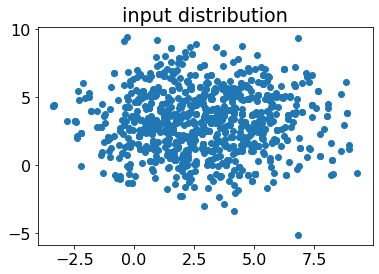

In [14]:
plt.scatter(X[:, 0], X[:, 1])
plt.title("input distribution")
plt.show()

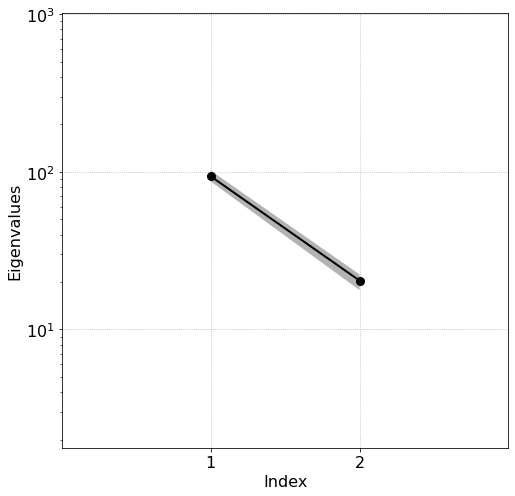

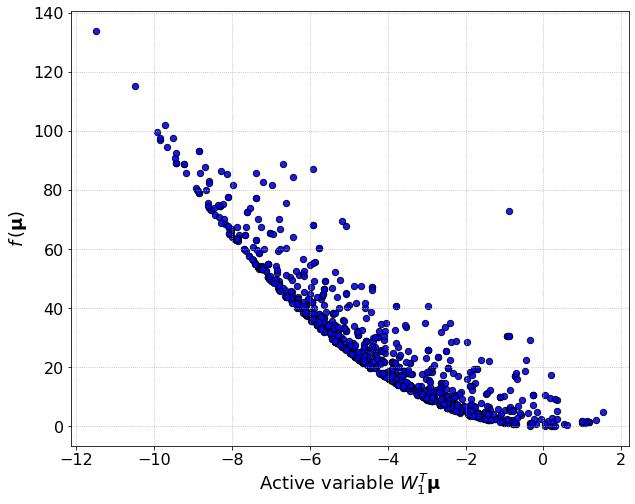

In [15]:
# Define the output of interest and compute the gradients
func = partial(radial, normalizer=None, generatrix=lambda x: x)
f = func(X)
df = egrad(func)(X)

# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)
asub.plot_eigenvalues()
asub.plot_sufficient_summary(X, f)

Use again parallel implementation of hmc sampling to compute the outputs of the optimal profile $g$ at the active components of the inputs X_test.

New position is
 [2.79578895 4.47139284]
Finished step -300  Threshold: 1.14033

New position is
 [3.79231017 3.00113615]
Finished step -299  Threshold: 1.09005

New position is
 [5.15534286 4.29317443]
  Sample rejected -298.  Threshold: 0.732912

New position is
 [-1.38248729  5.42861693]
Finished step -297  Threshold: 0.262724

New position is
 [7.77994621 0.93370631]
Finished step -296  Threshold: 0.895894

New position is
 [-2.15474227  1.24710428]
New position is
Finished step -295  Threshold: 0.871122

 [1.90371503 3.46273986]
Finished step -300  Threshold: 1.13593

New position is
 New position is
 [1.02756503 2.1457133 ]
Finished step -299  Threshold: 0.839468

New position is
 [8.89043176 1.34128251]
  Sample rejected -298.  Threshold: 0.166506

New position is
[8.84903615 2.07287293] [6.98264871 3.93360732]
Finished step -297  Threshold: 0.516091

New position is
 [1.75376751 2.13664316]
Finished step -296  Threshold: 2.19958

New position is
 [2.01631739 3.69585967]
Finishe

 [3.72468639 0.64664003]
Finished step -247  Threshold: 0.736156

New position is
 [4.01385685 3.29119765]
Finished step -246  Threshold: 1.31043

New position is
 
[1.83354719 0.61705617]
Finished step -245  Threshold: 0.723516

Finished step -243  Threshold: 1.14845

New position is
 [2.36140482 1.20444511]
Finished step -242  Threshold: 0.904004
New position is

 [2.47755868 4.63279938]
Finished step -244  Threshold: 1.25095

New position is
New position is
  [4.87027232 2.08264835]
  Sample rejected -241.  Threshold: 0.962094

New position is
 [ 2.03374323 -1.21344976][5.89733875 4.73761903]
Finished step -240  Threshold: 0.653787

New position is

Finished step -243  Threshold: 0.423171

New position is
 [-2.30241883  0.53911396] [4.02506853 8.6946554 ]
Finished step -242  Threshold: 0.445821

New position is

  Sample rejected -239.  Threshold: 0.28858
 [ 1.31505208 -2.10796203]
Finished step -241  Threshold: 1.28203

New position is

New position is
 [3.09080287 1.18825974]
Fini

New position is
  [3.5892823 2.8934756]
Finished step -179  Threshold: 1.72057

New position is
 [5.56725861 3.0579457 ]
Finished step -178  Threshold: 0.7114

[3.38286458 5.81011145]New position is

 [-1.24538652  2.75118943]
  Sample rejected -177.  Threshold: 0.533916

New position is
Finished step -198  Threshold: 0.812437
 
[-5.00877608  2.86157912]New position is

  Sample rejected -176.  Threshold: 0.0431268

New position is
 [3.68677313 0.52988648]
Finished step -197  Threshold: 1.0836
 
New position is
[0.80964698 4.85013759]
Finished step -175  Threshold: 0.915009

New position is
 [ 4.96758983 -1.19510073]
Finished step -174  Threshold: 0.485026

New position is
  [1.92779939 5.41976161]
Finished step -173  Threshold: 2.20328

[5.21033889 7.54987435]New position is

Finished step -196  Threshold: 0.354045
 [4.12514632 0.51794704]
Finished step -172  Threshold: 0.977235

New position is

New position is
  [3.08047239 3.28147818]
[ 1.43803372 -2.42107684]Finished step -171  Th

New position is
 [7.89139678 1.93035986]
  Sample rejected -112.  Threshold: 0.413537

New position is
 [6.09926348 5.676836  ]
  Sample rejected -155.  Threshold: 0.441832
 [7.58349842 1.65636832]
  Sample rejected -111.  Threshold: 0.467758


New position is
 [4.07485926 3.51146423]
New position is
 [2.83325694 1.33572736]
Finished step -110  Threshold: 1.50481
Finished step -154  Threshold: 0.947666

New position is

 [0.96535229 3.0634445 ]
New position is
 Finished step -153  Threshold: 0.929122
[-0.21566875  2.4048273 ]
  Sample rejected -109.  Threshold: 0.602507

New position is

 [2.73685916 2.52051968]
Finished step -152  Threshold: 1.23362

New position is
 New position is
[4.67521215 3.94541421]
 [2.71687596 3.49038644]
Finished step -108  Threshold: 1.0617

New position is
 Finished step -151  Threshold: 0.830501
[4.45479111 4.70911276]
Finished step -107  Threshold: 0.772917


New position is
New position is
 [1.25540094 1.77490904] [2.96711717 1.87902183]
Finished step -

New position is
 [7.83072943 4.05877394]
Finished step -105  Threshold: 1.07455

New position is
 [-1.93025741  3.51806698]
Finished step -104  Threshold: 0.993529

New position is
 [7.16893206 1.6169677 ]
Finished step -103  Threshold: 1.33443

New position is
[4.89019975 2.29722418] [-0.10218404  7.01338996]
Finished step  -56  Threshold: 0.90857

New position is

 Finished step -102  Threshold: 0.703577

[-2.40763848  3.15068397]New position is

  Sample rejected  -55.  Threshold: 0.252568

 [6.52376651 3.37671284]
Finished step -101  Threshold: 2.05302

New position is
 [3.35534446 4.51055324]
Finished step  -54  Threshold: 1.09481

New position is
New position is
  [0.39019586 2.44071246]
Finished step -100  Threshold: 1.34555
[1.22814265 1.07546395]

New position is
  Sample rejected  -53.  Threshold: 0.784893
 [3.76894662 4.28864263]
Finished step  -99  Threshold: 1.30481

New position is

New position is
  [3.02338008 0.61641212]
Finished step  -52  Threshold: 0.836281

[4.5283

 [2.41313492 7.33381122]
  Sample rejected   -2.  Threshold: 0.700655

New position is
[ 2.31753651 -2.08438993] [-1.92383336  5.23680445]
Finished step   -1  Threshold: 0.40315

New position is

 [ 7.08050886 -0.20933887]
Finished step    0  Threshold: 1.13365

New position is
 [-0.0494163   5.42945372]
Finished step  -45  Threshold: 0.462139
Finished step    1  Threshold: 1.89955

New position is

 [3.60578864 2.60335121]New position is
 
[3.49188256 7.93088792]
Finished step  -44  Threshold: 1.10095

New position is
Finished step    2  Threshold: 2.22887
 
New position is
 [ 0.9486795  -0.22285259][1.15519191 3.27253948]
Finished step    3  Threshold: 0.851056

New position is

Finished step  -43  Threshold: 1.72281
 [2.90113176 5.34425083]
Finished step    4  Threshold: 0.89518


New position is
New position is
  [3.32235611 3.52938167]
[5.63769192 3.77666165]Finished step    5  Threshold: 1.32268

New position is
 
[1.10226568 5.84514944]
Finished step    6  Threshold: 0.539158
Fi

 [0.24877082]
Finished step  -96  Threshold: 1.00371

New position is
 [-0.22755329]
Finished step  -95  Threshold: 0.989091

New position is
 [0.33966282]
Finished step  -94  Threshold: 1.00891

New position is
 [1.31874957]
Finished step  -93  Threshold: 0.89785

New position is
 [-2.94059211]
  Sample rejected  -92.  Threshold: 0.513266

New position is
 [0.0871364]
Finished step  -91  Threshold: 1.11657

New position is
 [0.58867885]
Finished step  -90  Threshold: 0.984977

New position is
 [-1.47384487]
Finished step  -89  Threshold: 0.819175

New position is
 [1.97290408]
Finished step  -88  Threshold: 0.946953

New position is
 [-2.42928188]
Finished step  -87  Threshold: 0.761642

New position is
 [1.2820397]
Finished step  -86  Threshold: 1.54956

New position is
 [0.37728739]
Finished step  -85  Threshold: 1.10477

New position is
 [1.40204403]
Finished step  -84  Threshold: 0.884395

New position is
 [-1.91823491]
  Sample rejected  -83.  Threshold: 0.801312

New position is

 [2.67099426]
Finished step  -90  Threshold: 1.01502

New position is
 [-2.88176438]
Finished step  -89  Threshold: 0.792484

New position is
 [2.57547676]
Finished step  -88  Threshold: 1.31121

New position is
 [-0.89319578]
Finished step  -87  Threshold: 1.47472

New position is
 [-2.67729926]
Finished step  -86  Threshold: 0.570084

New position is
 [4.25655265]
  Sample rejected  -85.  Threshold: 0.487492

New position is
 [2.36778202]
Finished step  -84  Threshold: 1.28636

New position is
 [0.2268251]
Finished step  -83  Threshold: 1.48966

New position is
 [-1.25668398]
Finished step  -82  Threshold: 0.851367

New position is
 [1.49521723]
Finished step  -81  Threshold: 1.01487

New position is
 [-1.60735501]
Finished step  -80  Threshold: 0.900253

New position is
 [3.181897]
  Sample rejected  -79.  Threshold: 0.609921

New position is
 [1.59598765]
Finished step  -78  Threshold: 1.08573

New position is
 [-1.2822979]
Finished step  -77  Threshold: 1.00215

New position is
 [

 [1.67287094]
Finished step  -77  Threshold: 0.83818

New position is
 [-0.58241696]
Finished step  -76  Threshold: 1.15498

New position is
 [0.7594739]
Finished step  -75  Threshold: 1.014

New position is
 [-0.91637149]
Finished step  -74  Threshold: 0.939079

New position is
 [-0.39370168]
Finished step  -73  Threshold: 1.07101

New position is
 [0.66743789]
Finished step  -72  Threshold: 1.00266

New position is
 [-0.6633384]
Finished step  -71  Threshold: 0.968025

New position is
 [1.35099399]
Finished step  -70  Threshold: 0.939193

New position is
 [-1.80152158]
Finished step  -69  Threshold: 0.824081

New position is
 [0.5461626]
Finished step  -68  Threshold: 1.34673

New position is
 [-0.14783409]
Finished step  -67  Threshold: 1.00531

New position is
 [-0.89142362]
Finished step  -66  Threshold: 0.921988

New position is
 [0.56957577]
Finished step  -65  Threshold: 1.07722

New position is
 [0.38228943]
Finished step  -64  Threshold: 1.0099

New position is
 [-2.10800007]

New position is
 [2.22994383]
Finished step  -66  Threshold: 0.821792

New position is
 [-0.9357345]
Finished step  -65  Threshold: 1.29004

New position is
 [1.33581234]
Finished step  -64  Threshold: 0.98251

New position is
 [-1.14780677]
Finished step  -63  Threshold: 0.976753

New position is
 [1.28445226]
Finished step  -62  Threshold: 1.03375

New position is
 [-0.84109676]
Finished step  -61  Threshold: 1.02428

New position is
 [1.80603408]
Finished step  -60  Threshold: 0.867528

New position is
 [-1.74996093]
Finished step  -59  Threshold: 0.930704

New position is
 [2.08381937]
Finished step  -58  Threshold: 0.990898

New position is
 [-0.97597429]
Finished step  -57  Threshold: 1.22116

New position is
 [3.90095023]
  Sample rejected  -56.  Threshold: 0.353869

New position is
 [0.79996984]
Finished step  -55  Threshold: 1.07183

New position is
 [1.00678988]
Finished step  -54  Threshold: 0.975061

New position is
 [-1.43429429]
Finished step  -53  Threshold: 0.864803

Ne

 [-0.69194516]
Finished step  -54  Threshold: 1.00123

New position is
 [1.35179944]
Finished step  -53  Threshold: 0.942676

New position is
 [-0.46495598]
Finished step  -52  Threshold: 1.0898

New position is
 [0.44424679]
Finished step  -51  Threshold: 1.02433

New position is
 [0.11280858]
Finished step  -50  Threshold: 1.00683

New position is
 [0.37516074]
Finished step  -49  Threshold: 0.996095

New position is
 [-0.40937671]
Finished step  -48  Threshold: 0.97863

New position is
 [0.26206523]
Finished step  -47  Threshold: 1.02497

New position is
 [1.24987717]
  Sample rejected  -46.  Threshold: 0.9076

New position is
 [1.07043351]
Finished step  -45  Threshold: 0.934682

New position is
 [-2.26874218]
  Sample rejected  -44.  Threshold: 0.665036

New position is
 [-1.66408755]
  Sample rejected  -43.  Threshold: 0.819021

New position is
 [-1.20780566]
  Sample rejected  -42.  Threshold: 0.921425

New position is
 [-0.48011743]
Finished step  -41  Threshold: 1.03668

New p

 [2.91811435]
  Sample rejected  -27.  Threshold: 0.846868

New position is
 [1.40289605]
Finished step  -26  Threshold: 1.38887

New position is
 [0.22883841]
Finished step  -25  Threshold: 1.13504

New position is
 [0.03422523]
Finished step  -24  Threshold: 0.999344

New position is
 [-1.42833241]
Finished step  -23  Threshold: 0.817141

New position is
 [2.21324285]
Finished step  -22  Threshold: 0.867445

New position is
 [-0.89815239]
Finished step  -21  Threshold: 1.29122

New position is
 [2.34260771]
Finished step  -20  Threshold: 0.740599

New position is
 [-2.64104602]
Finished step  -19  Threshold: 0.783284

New position is
 [4.45609758]
  Sample rejected  -18.  Threshold: 0.418351

New position is
 [2.89306276]
Finished step  -17  Threshold: 1.0239

New position is
 [-0.62454589]
Finished step  -16  Threshold: 1.75344

New position is
 [1.62161831]
Finished step  -15  Threshold: 0.881219

New position is
 [-1.03487561]
Finished step  -14  Threshold: 1.06284

New position i

 [-2.20997106]
Finished step   -7  Threshold: 0.659806

New position is
 [4.53333587]
  Sample rejected   -6.  Threshold: 0.330676

New position is
 [0.64559388]
Finished step   -5  Threshold: 1.54312

New position is
 [-2.02709692]
Finished step   -4  Threshold: 0.693298

New position is
 [4.34582963]
  Sample rejected   -3.  Threshold: 0.352242

New position is
 [4.24740297]
Finished step   -2  Threshold: 0.376394

New position is
 [-1.5518308]
Finished step   -1  Threshold: 3.08684

New position is
 [1.54784222]
Finished step    0  Threshold: 1.08083

New position is
 [0.60954141]
Finished step    1  Threshold: 1.15179

New position is
 [-0.97112445]
Finished step    2  Threshold: 0.917975

New position is
 [3.33676185]
Finished step    3  Threshold: 0.4859

New position is
 [-1.00340152]
Finished step    4  Threshold: 2.04577

New position is
 [1.20827229]
Finished step    5  Threshold: 1.01808

New position is
 [-1.18044457]
Finished step    6  Threshold: 0.947693

New position is

 [-1.1565132]
Finished step    6  Threshold: 0.897351

New position is
 [1.06183513]
Finished step    7  Threshold: 1.07464

New position is
 [-0.30048677]
Finished step    8  Threshold: 1.05189

New position is
 [0.57244265]
Finished step    9  Threshold: 1.00231


Fraction of samples rejected:  0

New position is
 [-1.94168373]
Finished step -100  Threshold: 1.12675

New position is
 [3.62148251]
Finished step  -99  Threshold: 0.536912

New position is
 [-2.31981638]
Finished step  -98  Threshold: 1.61862

New position is
 [2.60232606]
Finished step  -97  Threshold: 1.00884

New position is
 [0.08127029]
Finished step  -96  Threshold: 1.62831

New position is
 [0.28682204]
Finished step  -95  Threshold: 0.998938

New position is
 [0.35441805]
Finished step  -94  Threshold: 0.998152

New position is
 [1.13389539]
  Sample rejected  -93.  Threshold: 0.927737

New position is
 [2.1780846]
  Sample rejected  -92.  Threshold: 0.718724

New position is
 [1.33229932]
Finished step  -91  Thr

New position is
 [-0.84608074]
Finished step  -88  Threshold: 0.973442

New position is
 [0.95678848]
Finished step  -87  Threshold: 1.02881

New position is
 [-1.03928121]
Finished step  -86  Threshold: 0.939137

New position is
 [1.13131484]
Finished step  -85  Threshold: 1.0382

New position is
 [-0.91503863]
Finished step  -84  Threshold: 0.985429

New position is
 [1.30392105]
Finished step  -83  Threshold: 0.984898

New position is
 [-0.86837898]
Finished step  -82  Threshold: 1.02341

New position is
 [1.2570331]
Finished step  -81  Threshold: 0.985569

New position is
 [-0.88162344]
Finished step  -80  Threshold: 1.0124

New position is
 [1.99351057]
Finished step  -79  Threshold: 0.828042

New position is
 [-0.54786461]
Finished step  -78  Threshold: 1.26584

New position is
 [1.23651846]
Finished step  -77  Threshold: 0.945806

New position is
 [0.86109045]
Finished step  -76  Threshold: 1.05625

New position is
 [0.44563034]
Finished step  -75  Threshold: 1.03443

New positi

 [0.05983529]
Finished step  -67  Threshold: 1.0001

New position is
 [0.76804735]
Finished step  -66  Threshold: 0.97032

New position is
 [-0.8145847]
Finished step  -65  Threshold: 0.955842

New position is
 [1.88282623]
Finished step  -64  Threshold: 0.845812

New position is
 [-2.66310289]
  Sample rejected  -63.  Threshold: 0.669745

New position is
 [-1.38336475]
Finished step  -62  Threshold: 1.05312

New position is
 [1.76202992]
Finished step  -61  Threshold: 0.98122

New position is
 [-0.08869791]
Finished step  -60  Threshold: 1.22866

New position is
 [-1.1673307]
Finished step  -59  Threshold: 0.872121

New position is
 [1.45690434]
Finished step  -58  Threshold: 1.00319

New position is
 [-1.6166285]
Finished step  -57  Threshold: 0.890489

New position is
 [1.61569514]
Finished step  -56  Threshold: 1.08356

New position is
 [-1.29034258]
Finished step  -55  Threshold: 1.00493

New position is
 [0.81857766]
Finished step  -54  Threshold: 1.14234

New position is
 [0.106

 [1.53966131]
Finished step  -58  Threshold: 0.858677

New position is
 [-0.95651907]
Finished step  -57  Threshold: 1.05816

New position is
 [0.70947308]
Finished step  -56  Threshold: 1.07755

New position is
 [0.03788201]
Finished step  -55  Threshold: 1.02447

New position is
 [-0.06625996]
Finished step  -54  Threshold: 0.997186

New position is
 [-0.71781732]
Finished step  -53  Threshold: 0.943975

New position is
 [0.55799097]
Finished step  -52  Threshold: 1.04933

New position is
 [-1.42508724]
Finished step  -51  Threshold: 0.827901

New position is
 [1.50912238]
Finished step  -50  Threshold: 1.05399

New position is
 [0.19926934]
Finished step  -49  Threshold: 1.16123

New position is
 [-0.91319328]
Finished step  -48  Threshold: 0.912017

New position is
 [0.23846943]
Finished step  -47  Threshold: 1.096

New position is
 [-1.4470354]
  Sample rejected  -46.  Threshold: 0.81277

New position is
 [-0.17950946]
Finished step  -45  Threshold: 0.991692

New position is
 [-0.

 [0.33214475]
Finished step  -29  Threshold: 1.0059

New position is
 [0.15767738]
Finished step  -28  Threshold: 1.00263

New position is
 [-0.80222491]
Finished step  -27  Threshold: 0.928622

New position is
 [2.82127217]
Finished step  -26  Threshold: 0.603504

New position is
 [-1.69136594]
Finished step  -25  Threshold: 1.3536

New position is
 [2.24508162]
Finished step  -24  Threshold: 0.923357

New position is
 [-1.54989573]
Finished step  -23  Threshold: 1.12808

New position is
 [2.75556592]
Finished step  -22  Threshold: 0.729509

New position is
 [-2.66812968]
Finished step  -21  Threshold: 0.908732

New position is
 [3.33404842]
Finished step  -20  Threshold: 0.838343

New position is
 [-3.08811514]
Finished step  -19  Threshold: 0.96988

New position is
 [3.9320175]
Finished step  -18  Threshold: 0.735064

New position is
 [-1.79386958]
Finished step  -17  Threshold: 2.34772

New position is
 [1.79060396]
Finished step  -16  Threshold: 1.09382

New position is
 [-2.41246

 [2.12348148]
  Sample rejected  -21.  Threshold: 0.749168

New position is
 [1.27826988]
  Sample rejected  -20.  Threshold: 0.926819

New position is
 [-0.84744814]
Finished step  -19  Threshold: 0.947269

New position is
 [0.86303449]
Finished step  -18  Threshold: 1.04099

New position is
 [-2.14728025]
  Sample rejected  -17.  Threshold: 0.677891

New position is
 [-0.63661856]
Finished step  -16  Threshold: 0.990525

New position is
 [1.99033202]
Finished step  -15  Threshold: 0.799281

New position is
 [-1.5804873]
Finished step  -14  Threshold: 1.03104

New position is
 [3.95704845]
Finished step  -13  Threshold: 0.393495

New position is
 [-3.77313587]
Finished step  -12  Threshold: 0.927017

New position is
 [2.04648472]
Finished step  -11  Threshold: 2.61395

New position is
 [-1.79582291]
Finished step  -10  Threshold: 0.98332

New position is
 [2.1882796]
Finished step   -9  Threshold: 0.971922

New position is
 [-1.73183361]
Finished step   -8  Threshold: 1.0496

New posi

 [-1.07492098]
Finished step    1  Threshold: 0.91994

New position is
 [-0.46323342]
Finished step    2  Threshold: 1.09595

New position is
 [-1.60744203]
  Sample rejected    3.  Threshold: 0.801785

New position is
 [2.11125585]
Finished step    4  Threshold: 0.754909

New position is
 [-0.67937048]
Finished step    5  Threshold: 1.29141

New position is
 [1.76068556]
Finished step    6  Threshold: 0.857209

New position is
 [-3.24409404]
Finished step    7  Threshold: 0.483178

New position is
 [2.32191648]
Finished step    8  Threshold: 1.74196

New position is
 [-1.51698013]
Finished step    9  Threshold: 1.16901


Fraction of samples rejected:  0.1

New position is
 [0.5242579]
Finished step -100  Threshold: 1.00652

New position is
 [0.25217973]
Finished step  -99  Threshold: 1.01049

New position is
 [-0.44884025]
Finished step  -98  Threshold: 0.971845

New position is
 [1.57317671]
Finished step  -97  Threshold: 0.873936

New position is
 [-1.19405525]
Finished step  -96  T

New position is
 [-3.05875384]
Finished step -100  Threshold: 0.709785

New position is
 [1.32793829]
Finished step  -99  Threshold: 2.0663

New position is
 [-0.40929924]
Finished step  -98  Threshold: 1.09059

New position is
 [1.14482487]
Finished step  -97  Threshold: 0.947006

New position is
 [-1.25400429]
Finished step  -96  Threshold: 0.9225

New position is
 [2.10190281]
Finished step  -95  Threshold: 0.862233

New position is
 [-0.87182805]
Finished step  -94  Threshold: 1.25073

New position is
 [1.36901274]
Finished step  -93  Threshold: 0.965514

New position is
 [0.46208045]
Finished step  -92  Threshold: 1.11912

New position is
 [0.05095487]
Finished step  -91  Threshold: 1.00699

New position is
 [0.9923174]
Finished step  -90  Threshold: 0.945038

New position is
 [-0.2635906]
Finished step  -89  Threshold: 1.04426

New position is
 [-0.84688713]
Finished step  -88  Threshold: 0.93511

New position is
 [0.73764912]
Finished step  -87  Threshold: 1.05474

New position 

 [-1.66316016]
Finished step  -86  Threshold: 0.798836

New position is
 [0.58563758]
Finished step  -85  Threshold: 1.28741

New position is
 [-1.41256659]
Finished step  -84  Threshold: 0.83212

New position is
 [2.11918443]
Finished step  -83  Threshold: 0.890976

New position is
 [-1.39140934]
Finished step  -82  Threshold: 1.12838

New position is
 [0.89429404]
Finished step  -81  Threshold: 1.16061

New position is
 [-0.62231494]
Finished step  -80  Threshold: 0.995997

New position is
 [1.31737758]
Finished step  -79  Threshold: 0.94028

New position is
 [-0.11453113]
Finished step  -78  Threshold: 1.11022

New position is
 [-0.47890473]
Finished step  -77  Threshold: 0.973754

New position is
 [1.08240754]
Finished step  -76  Threshold: 0.962765

New position is
 [-0.65030792]
Finished step  -75  Threshold: 1.01813

New position is
 [-0.13907333]
Finished step  -74  Threshold: 1.04651

New position is
 [1.42877888]
Finished step  -73  Threshold: 0.882004

New position is
 [-0.7

 [3.8197683]
Finished step  -74  Threshold: 0.56776

New position is
 [-3.1087495]
Finished step  -73  Threshold: 1.25727

New position is
 [2.76195523]
Finished step  -72  Threshold: 1.36453

New position is
 [-1.51435011]
Finished step  -71  Threshold: 1.38795

New position is
 [2.61237669]
Finished step  -70  Threshold: 0.7663

New position is
 [-2.85588523]
Finished step  -69  Threshold: 0.783804

New position is
 [2.258877]
Finished step  -68  Threshold: 1.45473

New position is
 [-1.8778334]
Finished step  -67  Threshold: 1.02607

New position is
 [2.30217996]
Finished step  -66  Threshold: 0.960102

New position is
 [-2.28593359]
Finished step  -65  Threshold: 0.898066

New position is
 [2.64984567]
Finished step  -64  Threshold: 0.976451

New position is
 [-1.51776273]
Finished step  -63  Threshold: 1.3236

New position is
 [2.96757624]
Finished step  -62  Threshold: 0.658642

New position is
 [-2.29729311]
Finished step  -61  Threshold: 1.16945

New position is
 [3.06206273]
F

 [1.53452311]
Finished step  -49  Threshold: 0.857528

New position is
 [-0.85523203]
Finished step  -48  Threshold: 1.07552

New position is
 [0.5720676]
Finished step  -47  Threshold: 1.07056

New position is
 [1.14560398]
Finished step  -46  Threshold: 0.936241

New position is
 [-2.06203096]
Finished step  -45  Threshold: 0.72735

New position is
 [3.52184164]
Finished step  -44  Threshold: 0.59192

New position is
 [-4.45029705]
Finished step  -43  Threshold: 0.449777

New position is
 [4.16035744]
Finished step  -42  Threshold: 1.51601

New position is
 [-5.34376041]
  Sample rejected  -41.  Threshold: 0.316793

New position is
 [-3.10705278]
Finished step  -40  Threshold: 1.55635

New position is
 [3.97111869]
  Sample rejected  -39.  Threshold: 0.724739

New position is
 [2.01825049]
Finished step  -38  Threshold: 1.7869

New position is
 [-2.29172772]
Finished step  -37  Threshold: 0.816689

New position is
 [1.93524524]
Finished step  -36  Threshold: 1.25498

New position is


 [2.16985255]
Finished step  -28  Threshold: 0.878148

New position is
 [-1.63671092]
Finished step  -27  Threshold: 1.0733

New position is
 [0.8411094]
Finished step  -26  Threshold: 1.24805

New position is
 [-1.54205522]
Finished step  -25  Threshold: 0.823017

New position is
 [2.16017224]
Finished step  -24  Threshold: 0.909941

New position is
 [-1.68673478]
Finished step  -23  Threshold: 1.05424

New position is
 [1.07337378]
Finished step  -22  Threshold: 1.22867

New position is
 [-1.82318666]
Finished step  -21  Threshold: 0.780169

New position is
 [2.61099612]
  Sample rejected  -20.  Threshold: 0.84013

New position is
 [0.43133258]
Finished step  -19  Threshold: 1.36463

New position is
 [0.3525937]
Finished step  -18  Threshold: 1.00307

New position is
 [1.27435745]
  Sample rejected  -17.  Threshold: 0.905664

New position is
 [0.35127978]
Finished step  -16  Threshold: 1.00004

New position is
 [-0.45280396]
Finished step  -15  Threshold: 0.97381

New position is
 [0

 [-0.73067032]
Finished step   -1  Threshold: 1.00589

New position is
 [1.79422519]
  Sample rejected    0.  Threshold: 0.855742

New position is
 [1.74517737]
Finished step    1  Threshold: 0.866851

New position is
 [-0.74875066]
Finished step    2  Threshold: 1.15058

New position is
 [-0.82509656]
Finished step    3  Threshold: 0.988411

New position is
 [0.99472402]
Finished step    4  Threshold: 1.02015

New position is
 [-0.86616666]
Finished step    5  Threshold: 0.973734

New position is
 [0.51067539]
Finished step    6  Threshold: 1.07666

New position is
 [-1.67733966]
Finished step    7  Threshold: 0.769773

New position is
 [3.29344141]
Finished step    8  Threshold: 0.588629

New position is
 [-1.37207306]
Finished step    9  Threshold: 1.8463


Fraction of samples rejected:  0.1

New position is
 [1.03461444]
Finished step -100  Threshold: 1.2037

New position is
 [0.43026787]
Finished step  -99  Threshold: 1.05866

New position is
 [-1.69205419]
Finished step  -98  Thr

 [-2.33946882]
Finished step    9  Threshold: 0.603869


Fraction of samples rejected:  0

New position is
 [0.71701766]
Finished step -100  Threshold: 1.14491

New position is
 [-0.22249877]
Finished step  -99  Threshold: 1.01462

New position is
 [-0.03883269]
Finished step  -98  Threshold: 1.00848

New position is
 [0.82627228]
Finished step  -97  Threshold: 0.96661

New position is
 [0.79794559]
Finished step  -96  Threshold: 1.00304

New position is
 [-0.47754434]
Finished step  -95  Threshold: 1.00165

New position is
 [2.49170734]
  Sample rejected  -94.  Threshold: 0.661899

New position is
 [0.34985719]
Finished step  -93  Threshold: 1.0295

New position is
 [0.10097014]
Finished step  -92  Threshold: 1.00296

New position is
 [-0.62220849]
Finished step  -91  Threshold: 0.952617

New position is
 [-0.79839879]
Finished step  -90  Threshold: 0.975596

New position is
 [-0.68713568]
Finished step  -89  Threshold: 1.01632

New position is
 [1.73519975]
Finished step  -88  Thresh

 [-2.95357667]
Finished step  -90  Threshold: 0.719428

New position is
 [2.6839173]
Finished step  -89  Threshold: 1.30098

New position is
 [-4.03907866]
Finished step  -88  Threshold: 0.403734

New position is
 [4.68265633]
Finished step  -87  Threshold: 0.786328

New position is
 [-3.98979742]
Finished step  -86  Threshold: 1.31491

New position is
 [1.67648439]
Finished step  -85  Threshold: 3.33929

New position is
 [-2.61987808]
  Sample rejected  -84.  Threshold: 0.646736

New position is
 [-0.87487156]
Finished step  -83  Threshold: 1.1086

New position is
 [0.75438959]
Finished step  -82  Threshold: 1.0579

New position is
 [0.6167039]
Finished step  -81  Threshold: 1.01201

New position is
 [-0.53763444]
Finished step  -80  Threshold: 0.979068

New position is
 [1.72545409]
Finished step  -79  Threshold: 0.850023

New position is
 [0.01924198]
Finished step  -78  Threshold: 1.22109

New position is
 [0.09389077]
Finished step  -77  Threshold: 1.00116

New position is
 [1.374

New position is
 [0.19488134]
Finished step  -71  Threshold: 1.00071

New position is
 [0.00261845]
Finished step  -70  Threshold: 0.998329

New position is
 [1.25913279]
Finished step  -69  Threshold: 0.906857

New position is
 [-0.54099819]
Finished step  -68  Threshold: 1.06239

New position is
 [0.9284029]
Finished step  -67  Threshold: 0.990148

New position is
 [0.06831257]
Finished step  -66  Threshold: 1.04958

New position is
 [-0.63253895]
Finished step  -65  Threshold: 0.951712

New position is
 [2.32171943]
Finished step  -64  Threshold: 0.717117

New position is
 [-2.01391854]
Finished step  -63  Threshold: 1.00116

New position is
 [2.24732628]
Finished step  -62  Threshold: 1.02494

New position is
 [-0.54259993]
Finished step  -61  Threshold: 1.37375

New position is
 [1.61267991]
Finished step  -60  Threshold: 0.874482

New position is
 [-0.19370963]
Finished step  -59  Threshold: 1.17779

New position is
 [-1.8688637]
Finished step  -58  Threshold: 0.724465

New posit

 [0.37881744]
Finished step  -53  Threshold: 1.07138

New position is
 [-0.87131267]
Finished step  -52  Threshold: 0.922201

New position is
 [-0.80957067]
Finished step  -51  Threshold: 1.01001

New position is
 [-0.67195983]
Finished step  -50  Threshold: 1.02018

New position is
 [1.79840372]
  Sample rejected  -49.  Threshold: 0.847851

New position is
 [1.40341917]
Finished step  -48  Threshold: 0.930507

New position is
 [-0.48599741]
Finished step  -47  Threshold: 1.09871

New position is
 [0.2240588]
Finished step  -46  Threshold: 1.03324

New position is
 [-0.49061277]
Finished step  -45  Threshold: 0.967369

New position is
 [0.94633544]
Finished step  -44  Threshold: 0.982493

New position is
 [-1.1574985]
Finished step  -43  Threshold: 0.915588

New position is
 [0.5799284]
Finished step  -42  Threshold: 1.13267

New position is
 [0.06236474]
Finished step  -41  Threshold: 1.01431

New position is
 [1.54127759]
Finished step  -40  Threshold: 0.855409

New position is
 [-0.

New position is
 [-0.676887]
Finished step  -46  Threshold: 0.962219

New position is
 [2.11215637]
Finished step  -45  Threshold: 0.773866

New position is
 [-1.49789909]
Finished step  -44  Threshold: 1.09515

New position is
 [1.93179997]
Finished step  -43  Threshold: 0.964572

New position is
 [-0.70446059]
Finished step  -42  Threshold: 1.21866

New position is
 [2.4564237]
Finished step  -41  Threshold: 0.68942

New position is
 [-2.2582484]
Finished step  -40  Threshold: 0.960065

New position is
 [1.95898851]
Finished step  -39  Threshold: 1.22996

New position is
 [-0.43753185]
Finished step  -38  Threshold: 1.26753

New position is
 [0.4024935]
Finished step  -37  Threshold: 1.02346

New position is
 [0.36231954]
Finished step  -36  Threshold: 1.0015

New position is
 [-0.51270305]
Finished step  -35  Threshold: 0.968162

New position is
 [0.52426044]
Finished step  -34  Threshold: 1.025

New position is
 [0.59087716]
Finished step  -33  Threshold: 0.99562

New position is
 

New position is
 [0.43390774]
Finished step  -25  Threshold: 1.13169

New position is
 [-0.24464909]
Finished step  -24  Threshold: 0.993663

New position is
 [1.8566009]
  Sample rejected  -23.  Threshold: 0.799863

New position is
 [0.4076869]
Finished step  -22  Threshold: 1.00753

New position is
 [-0.5095104]
Finished step  -21  Threshold: 0.970159

New position is
 [0.36968015]
Finished step  -20  Threshold: 1.03227

New position is
 [-0.26389165]
Finished step  -19  Threshold: 0.989817

New position is
 [0.10717307]
Finished step  -18  Threshold: 1.01401

New position is
 [-1.11330899]
  Sample rejected  -17.  Threshold: 0.87807

New position is
 [-0.32677269]
Finished step  -16  Threshold: 0.981682

New position is
 [-0.29455525]
Finished step  -15  Threshold: 1.00243

New position is
 [-0.27369978]
Finished step  -14  Threshold: 1.00148

New position is
 [0.6735667]
Finished step  -13  Threshold: 0.992685

New position is
 [-0.88769814]
Finished step  -12  Threshold: 0.936298


 [-0.56067206]
Finished step   -5  Threshold: 1.15923

New position is
 [1.67010839]
Finished step   -4  Threshold: 0.864193

New position is
 [-0.94463127]
Finished step   -3  Threshold: 1.0936

New position is
 [2.3105592]
Finished step   -2  Threshold: 0.755138

New position is
 [-2.59763935]
  Sample rejected   -1.  Threshold: 0.789756

New position is
 [-1.66749812]
Finished step    0  Threshold: 1.11569

New position is
 [3.10801238]
Finished step    1  Threshold: 0.643406

New position is
 [-4.24211018]
  Sample rejected    2.  Threshold: 0.423362

New position is
 [-1.42401943]
Finished step    3  Threshold: 1.66228

New position is
 [1.35757986]
Finished step    4  Threshold: 1.08749

New position is
 [-1.33345013]
Finished step    5  Threshold: 0.94051

New position is
 [2.54139329]
  Sample rejected    6.  Threshold: 0.752348

New position is
 [1.34665762]
Finished step    7  Threshold: 1.06552

New position is
 [0.50366019]
Finished step    8  Threshold: 1.11174

New positi

 [-0.35708661]
Finished step    8  Threshold: 0.988557

New position is
 [-0.98998347]
Finished step    9  Threshold: 0.918542


Fraction of samples rejected:  0.1

New position is
 [-2.65707475]
Finished step -100  Threshold: 0.905633

New position is
 [3.85293598]
Finished step  -99  Threshold: 0.623953

New position is
 [-3.22108471]
Finished step  -98  Threshold: 1.20711

New position is
 [4.04561641]
  Sample rejected  -97.  Threshold: 0.735528

New position is
 [2.09119889]
Finished step  -96  Threshold: 1.85782

New position is
 [-1.44404392]
Finished step  -95  Threshold: 1.10347

New position is
 [2.00999326]
Finished step  -94  Threshold: 0.929227

New position is
 [-1.77864038]
Finished step  -93  Threshold: 0.97772

New position is
 [2.86238761]
Finished step  -92  Threshold: 0.7453

New position is
 [-3.00672528]
Finished step  -91  Threshold: 0.807235

New position is
 [4.25736691]
Finished step  -90  Threshold: 0.571973

New position is
 [-4.89467132]
  Sample rejected  

 [-1.36575688]
Finished step  -96  Threshold: 0.835836

New position is
 [-0.13387084]
Finished step  -95  Threshold: 1.19801

New position is
 [0.84159149]
Finished step  -94  Threshold: 0.968535

New position is
 [-0.15453033]
Finished step  -93  Threshold: 1.03146

New position is
 [-0.11696929]
Finished step  -92  Threshold: 1.00176

New position is
 [1.50477685]
  Sample rejected  -91.  Threshold: 0.866922

New position is
 [0.72102944]
Finished step  -90  Threshold: 0.979802

New position is
 [0.71030324]
Finished step  -89  Threshold: 1.00098

New position is
 [-2.97076352]
  Sample rejected  -88.  Threshold: 0.464172

New position is
 [-0.2588194]
Finished step  -87  Threshold: 1.01164

New position is
 [2.7607662]
Finished step  -86  Threshold: 0.583118

New position is
 [-0.67720445]
Finished step  -85  Threshold: 1.64407

New position is
 [2.06271305]
Finished step  -84  Threshold: 0.786032

New position is
 [-1.66154917]
Finished step  -83  Threshold: 1.02969

New position 

 [1.20792952]
Finished step  -86  Threshold: 1.36862

New position is
 [0.61342164]
Finished step  -85  Threshold: 1.07606

New position is
 [-2.06644903]
Finished step  -84  Threshold: 0.681908

New position is
 [2.08372251]
Finished step  -83  Threshold: 1.10175

New position is
 [-2.84746352]
  Sample rejected  -82.  Threshold: 0.65168

New position is
 [-0.88286247]
Finished step  -81  Threshold: 1.24129

New position is
 [2.29725626]
Finished step  -80  Threshold: 0.750583

New position is
 [-0.96797045]
Finished step  -79  Threshold: 1.31258

New position is
 [-0.62895874]
Finished step  -78  Threshold: 1.0538

New position is
 [3.38329755]
Finished step  -77  Threshold: 0.449781

New position is
 [-1.52550937]
Finished step  -76  Threshold: 1.85854

New position is
 [1.95568658]
Finished step  -75  Threshold: 0.965066

New position is
 [-0.82695518]
Finished step  -74  Threshold: 1.20494

New position is
 [0.71112244]
Finished step  -73  Threshold: 1.05396

New position is
 [1.0

 [2.00658813]
Finished step  -75  Threshold: 0.790836

New position is
 [-1.24942757]
Finished step  -74  Threshold: 1.12727

New position is
 [-0.01919861]
Finished step  -73  Threshold: 1.17037

New position is
 [1.12694519]
Finished step  -72  Threshold: 0.927897

New position is
 [0.09571716]
Finished step  -71  Threshold: 1.08

New position is
 [1.8051967]
Finished step  -70  Threshold: 0.801049

New position is
 [-1.40453268]
Finished step  -69  Threshold: 1.0254

New position is
 [1.53882766]
Finished step  -68  Threshold: 1.04157

New position is
 [-0.84939993]
Finished step  -67  Threshold: 1.07759

New position is
 [1.55969717]
Finished step  -66  Threshold: 0.923612

New position is
 [-0.8969803]
Finished step  -65  Threshold: 1.07415

New position is
 [1.10900234]
Finished step  -64  Threshold: 1.0152

New position is
 [-0.01801483]
Finished step  -63  Threshold: 1.07471

New position is
 [-0.54969726]
Finished step  -62  Threshold: 0.963005

New position is
 [1.56729396]
F

New position is
 [-0.07733427]
Finished step  -64  Threshold: 1.03476

New position is
 [-0.06807436]
Finished step  -63  Threshold: 1.00034

New position is
 [0.31021314]
Finished step  -62  Threshold: 1.00192

New position is
 [0.26260209]
Finished step  -61  Threshold: 1.00104

New position is
 [-0.30628]
Finished step  -60  Threshold: 0.984027

New position is
 [1.51848259]
Finished step  -59  Threshold: 0.874034

New position is
 [-0.67779041]
Finished step  -58  Threshold: 1.10045

New position is
 [-0.19904061]
Finished step  -57  Threshold: 1.04705

New position is
 [1.14785897]
Finished step  -56  Threshold: 0.931889

New position is
 [-0.45463068]
Finished step  -55  Threshold: 1.05194

New position is
 [-0.00453374]
Finished step  -54  Threshold: 1.02833

New position is
 [0.40459813]
Finished step  -53  Threshold: 0.996827

New position is
 [0.44683226]
Finished step  -52  Threshold: 0.998124

New position is
 [-0.27029197]
Finished step  -51  Threshold: 0.992568

New posit

 [-1.55967163]
Finished step  -46  Threshold: 1.57238

New position is
 [-0.19842537]
Finished step  -45  Threshold: 1.25638

New position is
 [1.30916367]
Finished step  -44  Threshold: 0.905924

New position is
 [-0.34120644]
Finished step  -43  Threshold: 1.09308

New position is
 [2.62508003]
  Sample rejected  -42.  Threshold: 0.620479

New position is
 [0.2397413]
Finished step  -41  Threshold: 1.01936

New position is
 [-1.00537087]
Finished step  -40  Threshold: 0.897349

New position is
 [0.99323091]
Finished step  -39  Threshold: 1.05279

New position is
 [-0.74958308]
Finished step  -38  Threshold: 0.991414

New position is
 [1.49573117]
Finished step  -37  Threshold: 0.922559

New position is
 [-0.84011917]
Finished step  -36  Threshold: 1.06894

New position is
 [2.05715431]
Finished step  -35  Threshold: 0.806616

New position is
 [-1.94578702]
Finished step  -34  Threshold: 0.939086

New position is
 [2.34873344]
Finished step  -33  Threshold: 0.966223

New position is
 

 [1.89960905]
Finished step  -30  Threshold: 0.823751

New position is
 [-1.06204934]
Finished step  -29  Threshold: 1.13692

New position is
 [0.10505621]
Finished step  -28  Threshold: 1.12714

New position is
 [0.96019731]
Finished step  -27  Threshold: 0.948494

New position is
 [1.31147305]
Finished step  -26  Threshold: 0.945378

New position is
 [-0.14545924]
Finished step  -25  Threshold: 1.10741

New position is
 [-0.46135548]
Finished step  -24  Threshold: 0.97687

New position is
 [0.3370495]
Finished step  -23  Threshold: 1.02822

New position is
 [1.29070473]
Finished step  -22  Threshold: 0.902509

New position is
 [-0.89389177]
Finished step  -21  Threshold: 1.01652

New position is
 [-0.88696608]
Finished step  -20  Threshold: 1.00117

New position is
 [0.31441511]
Finished step  -19  Threshold: 1.08943

New position is
 [1.65715272]
Finished step  -18  Threshold: 0.83364

New position is
 [-0.88971173]
Finished step  -17  Threshold: 1.10058

New position is
 [2.1073468

 [0.12950848]
Finished step   -9  Threshold: 1.20287

New position is
 [0.61166005]
Finished step   -8  Threshold: 0.983032

New position is
 [0.44054504]
Finished step   -7  Threshold: 1.01045

New position is
 [0.6093783]
Finished step   -6  Threshold: 0.989822

New position is
 [-1.79015709]
Finished step   -5  Threshold: 0.748482

New position is
 [3.19051892]
  Sample rejected   -4.  Threshold: 0.641678

New position is
 [2.15345181]
Finished step   -3  Threshold: 0.981334

New position is
 [-1.66008661]
Finished step   -2  Threshold: 1.06029

New position is
 [2.53299343]
Finished step   -1  Threshold: 0.823879

New position is
 [-2.40469444]
Finished step    0  Threshold: 0.931715

New position is
 [2.18586743]
Finished step    1  Threshold: 1.21566

New position is
 [-1.70863513]
Finished step    2  Threshold: 1.0562

New position is
 [2.45243684]
Finished step    3  Threshold: 0.861927

New position is
 [-1.86298371]
Finished step    4  Threshold: 1.10512

New position is
 [1.

 [1.30793391]
Finished step   -1  Threshold: 0.93962

New position is
 [-1.07163029]
Finished step    0  Threshold: 0.986892

New position is
 [1.33612561]
Finished step    1  Threshold: 1.00786

New position is
 [1.08134521]
Finished step    2  Threshold: 1.04473

New position is
 [0.07715067]
Finished step    3  Threshold: 1.0722

New position is
 [0.80372086]
Finished step    4  Threshold: 0.966533

New position is
 [-1.38078808]
  Sample rejected    5.  Threshold: 0.855093

New position is
 [-0.34432877]
Finished step    6  Threshold: 1.01456

New position is
 [-0.19180699]
Finished step    7  Threshold: 1.01048

New position is
 [0.84553111]
Finished step    8  Threshold: 0.970983

New position is
 [1.05222498]
Finished step    9  Threshold: 0.973586


Fraction of samples rejected:  0.1

New position is
 [-0.60284585]
Finished step -100  Threshold: 1.13075

New position is
 [0.85793722]
Finished step  -99  Threshold: 1.00589

New position is
 [1.70142447]
Finished step  -98  Thres

 [2.43417965]
Finished step    6  Threshold: 1.05342

New position is
 [0.00034321]
Finished step    7  Threshold: 1.52409

New position is
 [0.81299439]
Finished step    8  Threshold: 0.966947

New position is
 [-0.46462991]
Finished step    9  Threshold: 1.00456


Fraction of samples rejected:  0.1

New position is
 [-4.17835604]
  Sample rejected -100.  Threshold: 0.274352

New position is
 [-2.03290383]
  Sample rejected  -99.  Threshold: 0.854697

New position is
 [-1.59131526]
Finished step  -98  Threshold: 0.984142

New position is
 [2.62468452]
Finished step  -97  Threshold: 0.778971

New position is
 [-1.2107091]
Finished step  -96  Threshold: 1.41325

New position is
 [0.50672141]
Finished step  -95  Threshold: 1.15119

New position is
 [0.80537722]
Finished step  -94  Threshold: 0.975836

New position is
 [0.10726717]
Finished step  -93  Threshold: 1.03511

New position is
 [-0.47363544]
Finished step  -92  Threshold: 0.968817

New position is
 [2.00524902]
Finished step  -9

 [-1.16538393]
Finished step  -90  Threshold: 0.921023

New position is
 [1.59261467]
Finished step  -89  Threshold: 0.972864

New position is
 [-0.46460541]
Finished step  -88  Threshold: 1.14764

New position is
 [-0.95104539]
Finished step  -87  Threshold: 0.934244

New position is
 [1.01769835]
Finished step  -86  Threshold: 1.0388

New position is
 [-0.65153017]
Finished step  -85  Threshold: 1.0084

New position is
 [0.58933692]
Finished step  -84  Threshold: 1.03768

New position is
 [0.62061356]
Finished step  -83  Threshold: 0.997701

New position is
 [0.461414]
Finished step  -82  Threshold: 1.01011

New position is
 [-1.75079662]
  Sample rejected  -81.  Threshold: 0.750796

New position is
 [2.20151244]
Finished step  -80  Threshold: 0.716347

New position is
 [-1.55409344]
Finished step  -79  Threshold: 1.11036

New position is
 [0.25305327]
Finished step  -78  Threshold: 1.26599

New position is
 [-1.14236287]
Finished step  -77  Threshold: 0.873354

New position is
 [1.9

 [-2.60324108]
Finished step  -67  Threshold: 0.703916

New position is
 [2.22859498]
Finished step  -66  Threshold: 1.30572

New position is
 [-0.66045272]
Finished step  -65  Threshold: 1.34548

New position is
 [-0.84723806]
Finished step  -64  Threshold: 0.97286

New position is
 [-0.5856162]
Finished step  -63  Threshold: 1.03764

New position is
 [0.53948251]
Finished step  -62  Threshold: 1.03259

New position is
 [-1.38682947]
Finished step  -61  Threshold: 0.834967

New position is
 [2.5848582]
Finished step  -60  Threshold: 0.749411

New position is
 [-1.66360905]
Finished step  -59  Threshold: 1.23737

New position is
 [3.58533568]
  Sample rejected  -58.  Threshold: 0.501568

New position is
 [1.54614868]
Finished step  -57  Threshold: 1.11639

New position is
 [-0.93249246]
Finished step  -56  Threshold: 1.06427

New position is
 [1.07608711]
Finished step  -55  Threshold: 1.02662

New position is
 [-1.11228693]
Finished step  -54  Threshold: 0.941191

New position is
 [1.

 [-1.57144872]
Finished step  -45  Threshold: 0.814348

New position is
 [0.50363648]
Finished step  -44  Threshold: 1.26047

New position is
 [0.71819568]
Finished step  -43  Threshold: 0.984129

New position is
 [0.25752901]
Finished step  -42  Threshold: 1.02545

New position is
 [-1.15434716]
  Sample rejected  -41.  Threshold: 0.871209

New position is
 [-2.99679601]
  Sample rejected  -40.  Threshold: 0.447005

New position is
 [-0.73368668]
Finished step  -39  Threshold: 0.939036

New position is
 [1.22003908]
Finished step  -38  Threshold: 0.971535

New position is
 [-0.17610337]
Finished step  -37  Threshold: 1.08754

New position is
 [1.39892637]
Finished step  -36  Threshold: 0.889078

New position is
 [-1.54944062]
Finished step  -35  Threshold: 0.896682

New position is
 [1.66604313]
Finished step  -34  Threshold: 1.05034

New position is
 [-1.20997299]
Finished step  -33  Threshold: 1.03607

New position is
 [2.32702138]
Finished step  -32  Threshold: 0.791669

New positi

 [1.17840961]
Finished step  -29  Threshold: 0.931823

New position is
 [-0.42171792]
Finished step  -28  Threshold: 1.06058

New position is
 [2.02282676]
  Sample rejected  -27.  Threshold: 0.772869

New position is
 [-1.08531204]
Finished step  -26  Threshold: 0.906905

New position is
 [0.43986714]
Finished step  -25  Threshold: 1.12499

New position is
 [0.47219945]
Finished step  -24  Threshold: 0.998405

New position is
 [0.19276427]
Finished step  -23  Threshold: 1.00822

New position is
 [-0.29413067]
Finished step  -22  Threshold: 0.984064

New position is
 [1.07855534]
Finished step  -21  Threshold: 0.94786

New position is
 [-1.01208347]
Finished step  -20  Threshold: 0.960354

New position is
 [0.81763116]
Finished step  -19  Threshold: 1.07704

New position is
 [0.97664825]
Finished step  -18  Threshold: 0.980928

New position is
 [-0.07422803]
Finished step  -17  Threshold: 1.0524

New position is
 [0.5442862]
Finished step  -16  Threshold: 0.991712

New position is
 [0.

 [-0.23806837]
Finished step  -13  Threshold: 0.994348

New position is
 [0.16033056]
Finished step  -12  Threshold: 1.01246

New position is
 [0.02407627]
Finished step  -11  Threshold: 0.998671

New position is
 [-0.25519808]
Finished step  -10  Threshold: 0.987914

New position is
 [0.34093265]
Finished step   -9  Threshold: 1.01066

New position is
 [0.34428248]
Finished step   -8  Threshold: 0.999896

New position is
 [-1.28374653]
Finished step   -7  Threshold: 0.848212

New position is
 [1.80153248]
Finished step   -6  Threshold: 0.947919

New position is
 [-1.74528946]
  Sample rejected   -5.  Threshold: 0.930922

New position is
 [0.01025499]
Finished step   -4  Threshold: 1.24542

New position is
 [0.47178584]
Finished step   -3  Threshold: 0.993362

New position is
 [0.7562]
Finished step   -2  Threshold: 0.978876

New position is
 [-0.20520768]
Finished step   -1  Threshold: 1.01945

New position is
 [0.51100716]
Finished step    0  Threshold: 0.999925

New position is
 [-0

 [-0.87969538]
Finished step  -98  Threshold: 1.02363

New position is
 [-0.23246146]
Finished step  -97  Threshold: 1.07738

New position is
 [1.44114072]
Finished step  -96  Threshold: 0.88426

New position is
 [-1.49293261]
Finished step  -95  Threshold: 0.91853

New position is
 [2.80611922]
Finished step  -94  Threshold: 0.702938

New position is
 [-2.51786584]
Finished step  -93  Threshold: 0.992987

New position is
 [3.86464953]
  Sample rejected  -92.  Threshold: 0.582315

New position is
 [0.98387372]
Finished step  -91  Threshold: 1.68763

New position is
 [-2.49014089]
Finished step  -90  Threshold: 0.599685

New position is
 [1.53927972]
Finished step  -89  Threshold: 1.50861

New position is
 [-2.16626205]
Finished step  -88  Threshold: 0.755346

New position is
 [2.50661655]
Finished step  -87  Threshold: 0.986479

New position is
 [-1.84185047]
Finished step  -86  Threshold: 1.1358

New position is
 [2.51669628]
Finished step  -85  Threshold: 0.877038

New position is
 [

 [1.09328407]
Finished step  -89  Threshold: 0.935522

New position is
 [0.10259574]
Finished step  -88  Threshold: 1.07442

New position is
 [-0.58708094]
Finished step  -87  Threshold: 0.956731

New position is
 [-0.28072131]
Finished step  -86  Threshold: 1.02962

New position is
 [2.10598737]
Finished step  -85  Threshold: 0.744503

New position is
 [-1.36478953]
Finished step  -84  Threshold: 1.13111

New position is
 [2.3421693]
Finished step  -83  Threshold: 0.816481

New position is
 [-1.06525431]
Finished step  -82  Threshold: 1.30909

New position is
 [2.48533637]
Finished step  -81  Threshold: 0.724719

New position is
 [-3.44081923]
Finished step  -80  Threshold: 0.545002

New position is
 [3.23229523]
Finished step  -79  Threshold: 1.32087

New position is
 [-2.75830993]
Finished step  -78  Threshold: 1.08602

New position is
 [2.97386578]
Finished step  -77  Threshold: 1.04232

New position is
 [-3.20221361]
Finished step  -76  Threshold: 0.765278

New position is
 [4.277

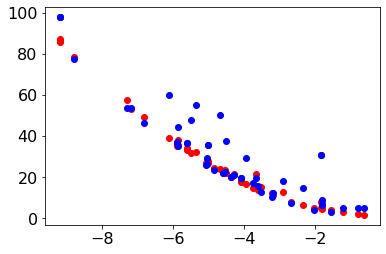

In [16]:
M_test = 50
X_test = chains(log_proposal,
                2,
                n_samples=25,
                epsilon=0.2,
                pr_args=(V, ),
                dim=2,
                n_burn=300)
f_test = func(X_test)
x_forward = asub.transform(X_test)[0]
optimal_profile = np.array([profile(x_forward[i, :], asub, func) for i in range(M_test)])
print(g.shape, x_forward.shape)
plt.scatter(x_forward, optimal_profile, c='r')
plt.scatter(x_forward, f_test, c='b')
plt.show()

Optimization restart 1/5, f = 104.47149150022022
Optimization restart 2/5, f = 104.47149149969478
Optimization restart 3/5, f = 104.47149150003867
Optimization restart 4/5, f = 104.47149150529151
Optimization restart 5/5, f = 104.47149150114885
Optimization restart 1/10, f = 186.15829576532093
Optimization restart 2/10, f = 186.15829576531613
Optimization restart 3/10, f = 186.15829576660533
Optimization restart 4/10, f = 186.15829576578417
Optimization restart 5/10, f = 186.15829576618833
Optimization restart 6/10, f = 186.15829576777733
Optimization restart 7/10, f = 186.7098532608116
Optimization restart 8/10, f = 186.1582957653819
Optimization restart 9/10, f = 186.15829576532843
Optimization restart 10/10, f = 186.1582957665873


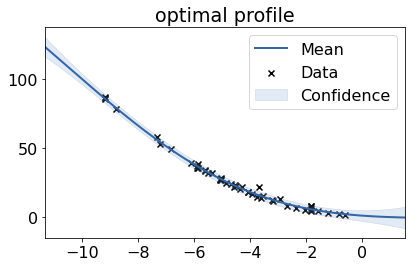

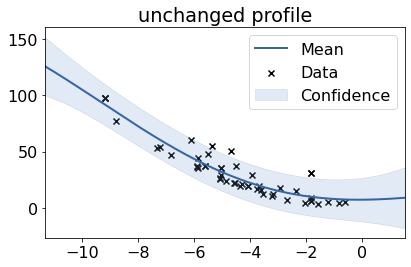

Relative Root Mean Square Error for optimal profile 185.947%
Relative Root Mean Square Error for unchanged profile 57.097%


In [17]:
gp_g = GPy.models.GPRegression(x_forward, optimal_profile.reshape(-1, 1))
gp_f = GPy.models.GPRegression(x_forward, f_test.reshape(-1, 1))

gp_g.constrain_positive('')
gp_g.optimize_restarts(5)

gp_f.constrain_positive('')
gp_f.optimize_restarts(10)

gp_g.plot(title="optimal profile")
gp_f.plot(title="unchanged profile")
plt.show()

y_g = gp_g.predict(x_forward)[0]
y_f = gp_f.predict(x_forward)[0]

def RRMSE(test, true):
    return np.sqrt(np.sum((test.reshape(-1) - true.reshape(-1))**2) )#/ np.sum((true - true.mean())**2))

print("Relative Root Mean Square Error for optimal profile {:.3f}%".format(RRMSE(y_g, g)))
print("Relative Root Mean Square Error for unchanged profile {:.3f}%".format(RRMSE(y_f, f_test)))

### Remarks

Try changing the potential V i.e. the probability density function $p(y,z)$ in order to study different input distributions.